<a href="https://colab.research.google.com/github/zzwony/Start_0920/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

1. transformers : Huggingface에 등록된 pretrained model/tokenizer를 불러올 수 있는 패키지
2. torch : 머신러닝 패키지
3. tqdm : batch별로 프로세스할 때 진행상황을 바로 보여주는 패키지

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install transformers

In [7]:
path = '/content/drive/MyDrive/3차 프로젝트_5팀/[참고자료] 문장 유형 분류 AI 경진대회/open'

In [19]:
import random
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer # baseline code용 tfidef vectorirzer(또는 tokenizer)
from sklearn import preprocessing
from sklearn.metrics import f1_score
from transformers import AutoModel, AutoTokenizer  # 사용하고자 하는 모델, 토크나이저 적용시 필요
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm # process bar 표시용
import warnings
warnings.filterwarnings(action='ignore') 

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device  # pt 코드에서 필요함

device(type='cpu')

# Data Load
예측하는데 ID는 필요없기 때문에 drop

In [11]:
df = pd.read_csv(path+'/train.csv')
df.drop(columns=['ID'], inplace=True)
test = pd.read_csv(path+'/test.csv')
test.drop(columns=['ID'], inplace=True)
submission = pd.read_csv(path+'/sample_submission.csv')

# reproducibility(재현성)를 위한 설정들
자세한 설명은 : https://tempdev.tistory.com/28

In [12]:
CFG = {
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':256,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False 
    torch.backends.cudnn.benchmark = True  
    # torch.use_deterministic_algorithms(True)

seed_everything(CFG['SEED']) # Seed 고정

# Train / Validation Split

In [16]:
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

# Model Load
- transformers 패키지를 통해서 pretrained된 모델을 불러올 수 있음.
- 불러오는 방법은 https://huggingface.co/models 여기서 model 이름을 검색
- 모델은 AutoModel.from_pretrained(), 토크나이저는 AutoTokenizer.from_pretrained()을 통해서 모델이름을 파라미터로 넣어주기.

##### AutoModel
- 모든 클래스에 걸쳐 Auto 클래스가 존재. 
- 모델에 관한 정보를 처음부터 명시하지 않아도 되며, 모델의 상세정보를 확인할 필요 없이 Model ID(ex: bert-base-cased) 만으로도 손쉽게 모델 구성 가능

##### tokenizer
- 토크나이저의 역할은 문장을 토큰이라고 하는 작은 단위 (더이상 나눌 수 없는 가장 작은 단위)로 나누어주고 
- pretrained tokenizer에 그 토큰이 어디에 저장되어 있는지 input_ids로 되돌려준다.

In [17]:
pretrained_model = 'klue/roberta-small'  # klue 모델 중에 젤 작은거
base_model = AutoModel.from_pretrained(pretrained_model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it f

In [22]:
# tokenizer 확인 및 테스트
tokenizer("힛걸 진심 최고로 멋지다.", "힛걸 진심 최고다 그 어떤 히어로보다 멋지다")

{'input_ids': [0, 3, 7254, 3841, 2200, 11980, 2062, 18, 2, 3, 7254, 3841, 2062, 636, 3711, 12717, 2178, 2062, 11980, 2062, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
tokenizer.tokenize("힛걸 진심 최고로 멋지다.", "힛걸 진심 최고다 그 어떤 히어로보다 멋지다")

['[UNK]',
 '진심',
 '최고',
 '##로',
 '멋지',
 '##다',
 '.',
 '[UNK]',
 '진심',
 '최고',
 '##다',
 '그',
 '어떤',
 '히어로',
 '##보',
 '##다',
 '멋지',
 '##다']

##### 적정선(len) 찾기

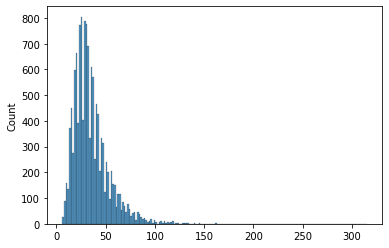

log value : 90.4092368060602


In [20]:
# input_ids 길이가 어떤지 histogram으로 그려본 것
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in train['문장']]
sns.histplot(tokenizer_len)
plt.show()

print(f'log value : {np.mean(tokenizer_len)+3*np.std(tokenizer_len)}') 
## 표준분산 3배수 안에 99프로의 데이터가존재, 표준분산 2배수안에는 95프로의 데이터가 존재

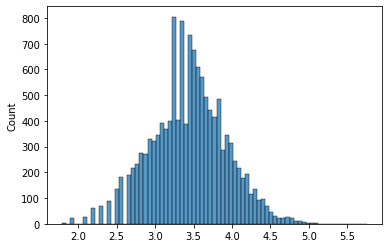

log value : 4.8974082584991345
original value : 133.94218592094492


In [21]:
# log 취하기
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}') 
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

## log를 취하는 이유는 한마디로 정규성을 높이고 분석(회귀분석 등)에서 정확한 값을 얻기 위함이다.
## (데이터 간 편차를 줄여 왜도1(skewness)와 첨도2(Kurtosis)를 줄일 수 있기 때문에 정규성이 높아진다.)
## log의 역할은 큰 수를 같은 비율의 작은 수로 바꿔 주는 것이며, 큰 수를 작게 만들고 복잡한 계산을 간편하게 하기위해 사용한다.
## (로그를 취하는 순간 그 수는 지수가 되어버리니, 값이 작아 진다.)

따라서, 적정선은 90에서 134 사이가 아닐까 생각됨.

# Data Pre-processing
- 1. 문장(Text) 벡터화
- 2. Label Encoding (유형, 극성, 시제, 확실성)

In [27]:
# 1.문장(Text) 벡터화
train_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in train["문장"]]
val_tokenized_texts = [tokenizer(sent,padding='max_length', max_length=90, truncation=True, return_tensors='pt')  for sent in val["문장"]]

# tokenization 확인
print(len(train_tokenized_texts), len(val_tokenized_texts))
print(train_tokenized_texts[0])
print(len(train_tokenized_texts[0]))

13232 3309
{'input_ids': tensor([[    0, 19426,  2270,  3810,  2259,  1980,  4426,  2052,  9644,  2470,
          5518,  2200,  2112,  2259, 13691,  2028,  2252,  2069,  3905,  2085,
          1295,  1415,  2062,  1980,  1072,  5087,  2116,  8922,  4147,  8084,
          4034,  3986,  2371,  2062,    18,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [28]:
# 2.Label Encoding(유형, 극성, 시제, 확실성)
type_le = preprocessing.LabelEncoder()
train["유형"] = type_le.fit_transform(train["유형"].values)
val["유형"] = type_le.transform(val["유형"].values)

polarity_le = preprocessing.LabelEncoder()
train["극성"] = polarity_le.fit_transform(train["극성"].values)
val["극성"] = polarity_le.transform(val["극성"].values)

tense_le = preprocessing.LabelEncoder()
train["시제"] = tense_le.fit_transform(train["시제"].values)
val["시제"] = tense_le.transform(val["시제"].values)

certainty_le = preprocessing.LabelEncoder()
train["확실성"] = certainty_le.fit_transform(train["확실성"].values)
val["확실성"] = certainty_le.transform(val["확실성"].values)

In [29]:
train_type = train["유형"].values # sentence type
train_polarity = train["극성"].values # sentence polarity
train_tense = train["시제"].values # sentence tense
train_certainty = train["확실성"].values # sentence certainty

train_labels = {
    'type' : train_type,
    'polarity' : train_polarity,
    'tense' : train_tense,
    'certainty' : train_certainty
}

val_type = val["유형"].values # sentence type
val_polarity = val["극성"].values # sentence polarity
val_tense = val["시제"].values # sentence tense
val_certainty = val["확실성"].values # sentence certainty

val_labels = {
    'type' : val_type,
    'polarity' : val_polarity,
    'tense' : val_tense,
    'certainty' : val_certainty
}

# SentenceTypeDataset 만들기

torch.utils.data의 Dataset의 child class인 SentenceTypeDataset을 만들어준다. 이는 pytorch neural network에 내 맘대로 
x가 뭔지 y가 뭔지 정한 dataset을 제공하기 위한 클래스이다. 만드는데 꼭 필요한 function은 총 3가지이다.

_ _ init _ _()
- x랑 y가 뭔지 저장해줘야 한다. 
- 이때 이번에는 텍스트 데이터를 다뤄주기때문에 dataframe, tokenizer, labels를 parameter로 넣어줬고 dataframe의 문장을 tokenizer로 토큰화 시킨다음 self.texts에 저장해주고 입력받은 labels는 그대로 self.labels에 저장해줬다. 
- batch에 들어가는 입력들은 input size가 다 같아야 한다. 따라서 tokenizer로 나온 값들을 그대로 넣어버리면 오류가 난다. 위 히스토그램에서 볼 수 있듯이 문장마다 다르기 때문. 따라서 위 값(90)으로 tokenizer의 max_length를 정해주고 max_length보다 작은 길이들은 padding으로 채워주고 긴 길이들은 truncation으로 잘라준다. 이때 max_length는 길면 길수록 training time이 늘어난다.
- tokenizer안에 return_tensors의 pt는 tensor로 tokenizer값을 리턴해준다는 뜻이다.

_ _ len _ _()
- self.texts의 길이는 리턴해줍니다.

_ _ getitem _ _()
- idx에 해당되는 x와 y를 리턴해줍니다.
- x는 self.texts에서 가져오고 y는 그 텍스트(x)에 해당되는 type, polarity, tense, certainty를 리턴하면 됩니다.
- 나중 코드에서 나오겠지만 미리 설명을 하자면 labels는 train, val set에서만 dictionary형태로 주어진다. 이때 type, polarity, tense, certainty가 key고 해당 레이블에 해당되는 값을 one-hot encoding한게 value다. 
- dictionary에 저장된 형태는 list고 pytorch에는 tensor 형태로 넣어줘야하기 때문에 torch.Tensor()로 형태를 바꾸어준다.
- test set의 경우 labels이 주어지지 않기 때문에 똑같은 길이지만 -1로 채워놓은 tensor를 리턴해준다.

In [24]:
class SentenceTypeDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels=None):
        texts = dataframe['문장'].values.tolist()

        self.texts = [tokenizer(text, padding='max_length', max_length=90, truncation=True, return_tensors='pt') for text in texts]   # pt pyorch, tf tensorflow
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        if self.labels is not None:
            type_tmp = self.labels['type'][idx]
            polarity_tmp = self.labels['polarity'][idx]
            tense_tmp = self.labels['tense'][idx]
            certainty_tmp = self.labels['certainty'][idx]
            return text, torch.Tensor(type_tmp), torch.Tensor(polarity_tmp), torch.Tensor(tense_tmp), torch.Tensor(certainty_tmp)
        else:
            return text, torch.Tensor([-1,-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1,-1]), torch.Tensor([-1,-1])

# Classifier class 만들기

\__init__()
- 우선 nn.Module의 child class이기 때문에 \__init__() 안에 super().\__init__()을 불러주고 base_model을 통해서 받을 pretrained_model을 self.klue에 저장한다.
이때 klue의 output features는 768이다. 확인방법은 base_model을 셀에 쳐보면 된다. (더 쉬운 방법이 있으면 알려주세요)

- transfer learning의 기본적인 방법은 중간에 hidden layer는 pretrained_model의 것을 이용하고 output layer를 내가 원하는 방향으로 만들어서 training 하는 것이다. 따라서, self.fc1, self.type_clf, self.softmax 등등 다양한 레이어들을 추가해줬다. 이때 self.fc1에는 nn.Linear(768, 32)를 저장해줬는데, 이는 in_feature로 768, out_feature로는 32를 내보낸다는 뜻이다. 일반적으로 알고 있는 dense layer의 역할을 한다. 그 다음으로는 self.relu에 nn.ReLU()를 저장해서 activation function으로 사용해줬다. 그 다음으로는 multilabel classification 문제이기 때문에 각 label마다 nn.Linear(32, # of types)으로 레이어를 만들어줬다. 이때 # of types만큼의 out_feature가 필요한 이유는 types들을 one-hot encoding을 해줬기 때문이다. 그 다음으로는 classification에 많이 사용되는 nn.Softmax(dim=1)을 넣어줬다. softmax에서 나온 값들의 합은 1로써 어느 type에 해당되는지 확률들을 리턴해준다. 이때 합해져야되는 값들이 dim=1에 있기때문에 dim=1이라는 파라미터를 넣어주었다.

\__forward__()
- 그 다음으로 꼭 작성해줘야 하는 function은 forward다. (backward는 필요없음) 여기서는 위에서 작성한 레이어들을 어느 순서로 지나칠지 순서를 정해주는 단계이다. 우선, pretrained_model을 지나고 나온 output을 fc1과 relu에 넘겨주고 그 다음으로는 각 label의 clf-softmax 페어를 지나쳐준다. 그리고 나온 4개의 output을 리턴해주면 된다. 
- multilabel이기 때문에 4개의 값을 리턴해주는거지 단순하게 binary 또는 multiclassification이면 보통 1개의 output만을 리턴해주면 된다.
- 아래 코드에 써있듯이 input_ids는 토큰에 해당되는 ids들, attention_mask는 어느 토큰에 집중해야되는지 알려주는 역할을 한다. 이는 왜 필요하나 하면 padding 단계에서 추가된 padding token에 대한 접근을 막기위해 사용된다.

In [25]:
class SentenceClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.klue = base_model # from transformers package

        self.fc1 = nn.Linear(768, 32)
        self.relu = nn.ReLU()
        self.type_clf = nn.Linear(32,4)
        self.polarity_clf = nn.Linear(32,3)
        self.tense_clf = nn.Linear(32,3)
        self.certainty_clf = nn.Linear(32,2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        # input_ids : token's id / attention_mask : make a model to focus on which token
        klue_out = self.klue(input_ids= input_ids, attention_mask = attention_mask)[0][:,0]

        x = self.fc1(klue_out)
        x = self.relu(x)

        type_output = self.type_clf(x)
        type_output = self.softmax(type_output)
        polarity_output = self.polarity_clf(x)
        polarity_output = self.softmax(polarity_output)
        tense_output = self.tense_clf(x)
        tense_output = self.softmax(tense_output)
        certainty_output = self.certainty_clf(x)
        certainty_output = self.softmax(certainty_output)

        return type_output, polarity_output, tense_output, certainty_output

# sentence_train 만들기

다음으로는! training 단계이다.

우선 val_loss를 기준으로 early_stop을 할건지 말건지 정하기 때문에 best_val_loss를 설정해주었고, crossentropyloss를 이용할건데 작아질수록 좋은 값이기 때문에 최초값은 높은 값으로 설정해주었다. 

그 다음으로는 criterion인데 이는 loss function이다. 4개의 다른 label들이 있기 때문에 dictionary에 4개를 넣어주었다. 나중 단계에서 criterion에 있는 CrossEntropyLoss를 통해서 true값과 pred값의 차이를 구하고 어떤 방향으로 weights를 조정해야되는지 정한다.

optimizer는 어떤 방식으로 최적화를 한걸지 정해주는 변수인데, 일반적으로 많이 쓰이는 Adam을 써줬다. Adam 안에는 모델의 파라미터(model.parameters())와 learning_rate를 넣어주었다. 위에서 언급했듯이 이때 learning_rate가 큰지 작은지에 따라 training 속도가 결정난다. 그 다음으로는 모델을 gpu로 보내주었다. 이 코드가 있어야 gpu를 사용해서 training 한다.
- mac m칩 유저의 경우 “PYTORCH_ENABLE_MPS_FALLBACK=1”를 설정해줘야 mps가 안되는 코드는 cpu로 계산을 해준다. (2022/12/16 cumsum은 mps로 계산이 안됨)

그리고 주어진 epochs만큰 for loop을 돌리는데 그 밑에 있는 total_acc_train은 total_f1_train으로 바뀌어야 맞다. 이 부분은 중간에 f1 계산하는 코드 넣는거를 까먹고 못하고 코드를 그대로 돌려서 남은 것이니 만약 이 코드 그대로 돌린다고 하면 바꾸어주길 바란다. 그 밑에 total_loss_train은 epoch별로 loss 값이 어땠는지 기록해주기 위해 만든 변수다.

그 다음으로는 model.train()이 있는데 이는 model을 training 모드로 만들어주는거다. 이렇게 해야 weight들이 업데이트된다. 이와 반대로 나중에 val이나 test set을 모델에 넘겨줄때는 model.eval()을 불러줘야한다. 이래야 weights들이 업데이트 되지 않는다.

그 다음으로는 train_dataloader를 for loop으로 돌려주는데 뒤에 나오겠지만 dataloader는 지정해준 batch_size만큼 item의 x와 y를 넘겨준다. 이때 쓰이는 것이 위에서 만들어준 SentenceTypeDataset의 getitem()이다. 따라서, 5개의 변수 (train_input, type_label, polarity_label, tense_label, certainty_label)로 받아야한다. 그 다음으로는 train_input에 있는 attention_mask와 input_ids와 label들을 device로 넘겨준다.

그리고 training을 시작하기 전에 optimizer.grad()를 설정해줘서 매 epoch마다 전에 썼던 값들을 기억하는 것이 아니라 0 베이스에서 시작하게 해준다. epoch를 통한 값들의 정확한 업데이트를 위해서는 꼭 필요한 코드다.

그리고 나서 model에 input_ids와 attention_mask를 넣어서 얻은 4개의 값들을 저장해준다. 이때 이 값들은 각 label마다 one-hot encoding된 컬럼에 해당될 확률들이다. 바로 다음에 이 값들은 criterion에 있는 CrossEntropyLoss()로 들어가서 실제와 얼마나 유사한지 계산되고 그 계산된 값을 total_loss_train에 저장해준다.

그 다음으로는 계산된 loss 값을 바탕으로 backpropagation(loss.backward()과 optimizer.step()을 통해서)을 진행하여 weights들을 업데이트해준다.

이렇게 training data를 다 거쳤다면 그 다음은 validation data 차례다. 우선 with torch.no_grad()과 model.eval()을 불러주어서 weights들을 업데이트하는게 아니라는 것을 선언해준다. 그 후에는 training data에서 했던 방식이랑 다 같지만 optimizer.zero_grad(), loss.backward(), optimier.step()만 빠진다. weights들을 업데이트하지 않기 때문.

그 다음으로는 지금까지 저장한 loss와 metric을 프린트해주고, val_loss가 좋아졌는지 여부에 따라서 모델을 저장할 것인지 early stop 할 것인지 정해준다.

In [30]:
def sentence_train(model, train_dataloader, val_dataloader, learning_rate, epochs, model_nm):
    best_val_loss = 99999999999999 # setting max (act as infinity)
    early_stopping_threshold_count = 0

    criterion = {
        'type' : nn.CrossEntropyLoss().to(device),
        'polarity' : nn.CrossEntropyLoss().to(device),
        'tense' : nn.CrossEntropyLoss().to(device),
        'certainty' : nn.CrossEntropyLoss().to(device)
    }

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)

    for epoch in range(epochs):
        total_f1_train = 0
        total_loss_train = 0
        
        model.train() # sets into the training mode
        
        for train_input, type_label, polarity_label, tense_label, certainty_label in tqdm(train_dataloader):
            attention_mask = train_input['attention_mask'].to(device)
            input_ids = train_input['input_ids'].squeeze(1).to(device)
            type_label = type_label.to(device)
            polarity_label = polarity_label.to(device)
            tense_label = tense_label.to(device)
            certainty_label = certainty_label.to(device)

            optimizer.zero_grad() # 초기화
            
            type_output, polarity_output, tense_output, certainty_output = model(input_ids, attention_mask) # from the forward function
            
            loss = 0.25*criterion['type'](type_output, type_label.float()) + \
                   0.25*criterion['polarity'](polarity_output, polarity_label.float()) + \
                   0.25*criterion['tense'](tense_output, tense_label.float()) + \
                   0.25*criterion['certainty'](certainty_output, certainty_label.float())
            total_loss_train += loss.item()

            loss.backward() # 역전파
            optimizer.step() # 한단계 진행


        with torch.no_grad(): # since we should not change gradient for validation 
            total_acc_val = 0
            total_loss_val = 0
            
            model.eval() # deactivate training
            
            # same process as the above
            for val_input, vtype_label, vpolarity_label, vtense_label, vcertainty_label in tqdm(val_dataloader):
                attention_mask = val_input['attention_mask'].to(device)
                input_ids = val_input['input_ids'].squeeze(1).to(device)

                vtype_label = vtype_label.to(device)
                vpolarity_label = vpolarity_label.to(device)
                vtense_label = vtense_label.to(device)
                vcertainty_label = vcertainty_label.to(device)
                
                vtype_output, vpolarity_output, vtense_output, vcertainty_output = model(input_ids, attention_mask) # from the forward function

                loss = 0.25*criterion['type'](vtype_output, vtype_label.float()) + \
                        0.25*criterion['polarity'](vpolarity_output, vpolarity_label.float()) + \
                        0.25*criterion['tense'](vtense_output, vtense_label.float()) + \
                        0.25*criterion['certainty'](vcertainty_output, vcertainty_label.float())

                total_loss_val += loss.item()

            
            print(f'Epochs: {epoch + 1} '
                  f'| Train Loss: {total_loss_train / len(train_dataloader): .3f} '
                  f'| Train Accuracy: {total_acc_train / (len(train_dataloader.dataset)): .3f} '
                  f'| Val Loss: {total_loss_val / len(val_dataloader): .3f} '
                  f'| Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            if best_val_loss > total_loss_val:
                best_val_loss = total_loss_val # saving only the best one
                torch.save(model, f"model/{model_nm}.pt")
                print("Saved model")
                early_stopping_threshold_count = 0
            else:
                early_stopping_threshold_count += 1 # checking how many epochs have passed that val_loss didn't increase
                
            if early_stopping_threshold_count >= 3: # ==> patience=1
                print("Early stopping")
                break

# Dataset 준비
우선 train에서 label을 제외한 나머지 컬럼들만 킵해주고 그중에서도 유형,극성,시제,확실성을 pd.get_dummies로 one-hot encoding해준다.

In [31]:
train_tmp = train[['문장', '유형', '극성', '시제', '확실성']]
train_tmp = pd.get_dummies(train_tmp, columns=['유형', '극성', '시제', '확실성'])
train_tmp

,문장,유형_0,유형_1,유형_2,유형_3,극성_0,극성_1,극성_2,시제_0,시제_1,시제_2,확실성_0,확실성_1
0,용산구청 관계자는 ＂재정이 열악한 지자체로서는 1800억원을 마련할 수 없다＂며 서...,0,1,0,0,1,0,0,1,0,0,0,1
1,부산시는 이처럼 부산이 가파른 상승세를 보이는 이유에 대해 지난해부터 추진하고 있는...,0,1,0,0,1,0,0,1,0,0,0,1
2,"그러나 미숙아, 만성호흡기질환, 선천 심장병, 선천 면역결핍질환, 암환자 등의 고위...",0,1,0,0,1,0,0,0,0,1,0,1
3,탁구 종목에서 중국 대표팀 위상이 뛰어나기 때문이다.,0,0,0,1,1,0,0,0,0,1,0,1
4,이 논문에 따르면 ＇BT-11＇은 뇌의 신경전달물질인 아세틸콜린을 분해하는 효소의 ...,0,1,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13227,우리가 익히 아는 대로 임꺽정은 신출귀몰했다.,0,1,0,0,1,0,0,1,0,0,0,1
13228,김 상무보는 ＂실제 이용자 수와 인당 사용시간 등 주요 데이터가 매년 두 자릿수 상...,0,1,0,0,1,0,0,1,0,0,0,1
13229,＇디폴트 옵션＇의 필요성을 주장해온 쪽이 항상 사례로 들어온 것이 ＇401K＇로 불...,1,0,0,0,1,0,0,0,0,1,0,1
13230,1992년부터 선양시 조선족노인협회를 후원하기 시작해 1997년에는 1500㎡ 건물...,0,1,0,0,1,0,0,1,0,0,0,1


##### 각 label별로 뽑아서 train_labels에 dictionary형태로 저장

In [32]:
train_type = train_tmp.iloc[:,1:5].values.tolist()
train_polarity = train_tmp.iloc[:,5:8].values.tolist()
train_tense = train_tmp.iloc[:,8:11].values.tolist()
train_certainty = train_tmp.iloc[:,11:13].values.tolist()
train_labels = {
    'type': train_type,
    'polarity': train_polarity,
    'tense': train_tense,
    'certainty': train_certainty
}

val_tmp = val[['문장', '유형', '극성', '시제', '확실성']]
val_tmp = pd.get_dummies(val_tmp, columns=['유형', '극성', '시제', '확실성'])

val_type = val_tmp.iloc[:,1:5].values.tolist()
val_polarity = val_tmp.iloc[:,5:8].values.tolist()
val_tense = val_tmp.iloc[:,8:11].values.tolist()
val_certainty = val_tmp.iloc[:,11:13].values.tolist()
val_labels = {
    'type': val_type,
    'polarity': val_polarity,
    'tense': val_tense,
    'certainty': val_certainty
}

train, val set가 준비되었다면 위에서 만든 SetenceTypeDataset에 dataframe, tokenizer, labels들을 넣어주고 SentenceTypeDataset, batch_size는 필수적으로 값을 정해서 DataLoader에 넣어준다. 위에서 잠깐 언급했듯이 DataLoader는 지정된 batch_size만큼 item들을 모델에 넘겨주어서 training 할 수 있게 해준다. 

여기서 shuffle는 item들을 랜덤하게 고른다는 의미.

##### DataLoader

In [33]:
train_dataloader = DataLoader(SentenceTypeDataset(train_tmp, tokenizer, train_labels), batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0) # num_workers: how many subprocesses to use for data loading  
val_dataloader = DataLoader(SentenceTypeDataset(val_tmp, tokenizer, val_labels), batch_size=CFG['BATCH_SIZE'], num_workers=0)

##### base_model (klue를 이용한 pretrained_model)을 기반으로해서 SentenceClassifier를 불러주기

In [34]:
model = SentenceClassifier(base_model)
## 여기까지가 training 할 수 있는 상태에 온 것이다.

# Training
- 위에서 만든 sentence_train function에 필요한 파라미터들을 보내주어서 training을 시작해준다.

- 위에서 말했듯이 f1을 계산 안하고 accuracy를 그대로 남겨주었기 때문에 accuracy는 계속 0이다.

In [ ]:
sentence_train(model, train_dataloader, val_dataloader, CFG['LEARNING_RATE'], CFG['EPOCHS'], 'kclue')

  0%|          | 0/52 [00:00<?, ?it/s]